In [1]:
from openvino.inference_engine import IENetwork, IEPlugin
import cv2 as cv
import matplotlib.pyplot as plt

In [6]:
plugin = IEPlugin(device="CPU")
plugin.add_cpu_extension("/opt/intel/openvino/deployment_tools/inference_engine/lib/intel64/libcpu_extension_avx2.so")

model_xml = "models/age-gender-recognition-retail-0013.xml"
model_bin = "models/age-gender-recognition-retail-0013.bin"

lmmodel_xml = "models/facial-landmarks-35-adas-0002.xml"
lmmodel_bin = "models/facial-landmarks-35-adas-0002.bin"

In [7]:
def load_model(plugin, model, weights):
    """
    Load OpenVino IR Models

    Input:
    Plugin = Hardware Accelerator
    Model = model_xml file 
    Weights = model_bin file
    
    Output:
    execution network (exec_net)
    """
    #  Read in Graph file (IR) to create network
    net = IENetwork(model, weights) 
    # Load the Network using Plugin Device
    exec_net = plugin.load(network=net)
    return net, exec_net

def age_gender_preprocessing(n, c, h, w):
    """
    Image Preprocessing steps, to match image 
    with Input Neural nets
    
    N=1, Channel=3, Height=62, Width=62
    """
    blob = cv.resize(image, (w, h)) # Resize width & height
    blob = blob.transpose((2, 0, 1)) # Change data layout from HWC to CHW
    blob = blob.reshape((n, c, h, w))
    return blob

def landmark_preprocessing(n, c, h, w):
    """
    Image Preprocessing steps, to match image 
    with Input Neural nets
    
    N=1, Channel=3, Height=60, Width=60
    """
    blob = cv.resize(image, (w, h)) # Resize width & height
    blob = blob.transpose((2, 0, 1)) # Change data layout from HWC to CHW
    blob = blob.reshape((n, c, h, w))
    return blob

# Age Gender

In [5]:
net, exec_net = load_model(plugin, model_xml,model_bin)

input_net = 'data'
output_age_net = 'age_conv3'
output_gender_net = 'prob'

n,c,h,w = net.inputs[input_net].shape


In [174]:
net.inputs

{'data': <openvino.inference_engine.ie_api.InputInfo at 0x7f4e1b85ae90>}

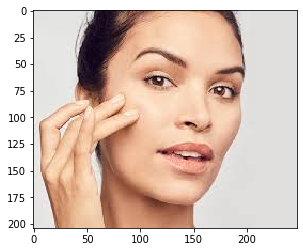

In [93]:
image = cv.imread('women.jpeg')
plt.imshow(image[:,:,::-1])

In [94]:
blob = age_gender_preprocessing(n,c,h,w)
req_handle = exec_net.start_async(0, {input_net:blob})

In [173]:
status = req_handle.wait()
age = req_handle.outputs[output_age_net]
age = 'above 30' if age[0,0,0,0] *100 >= 30 else 'below 30'
age

'below 30'

In [175]:
gender = req_handle.outputs[output_gender_net]

gender

array([[[[0.8799798 ]],

        [[0.12002016]]]], dtype=float32)

In [168]:
dic = ['Female', 'Male']
gender[0,:,0,0].argmax()

0

In [112]:
gender[0][1][0][0]

0.12002016

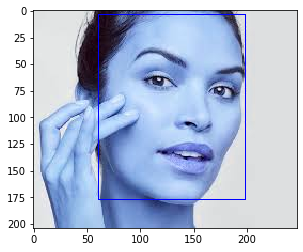

In [27]:
for detection in res[0][0]:
    confidence = float(detection[2])
    xmin = int(detection[3] * image.shape[1])
    ymin = int(detection[4] * image.shape[0])
    xmax = int(detection[5] * image.shape[1])
    ymax = int(detection[6] * image.shape[0])
    if confidence > 0.9:
        cv.rectangle(image, (xmin, ymin), (xmax, ymax), (0,0,255))

plt.imshow(image)

# Facial Landmark

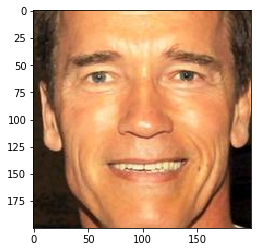

In [68]:
image = cv.imread('frontal_face.jpg')
plt.imshow(image[:,:,::-1])

(200, 200, 3)

In [58]:
xmin,ymin = 0,0
xmax,ymax = 200,200
height = ymax - ymin
width = xmax - xmin 

In [25]:
net, exec_net = load_model(plugin, lmmodel_xml, lmmodel_bin)

input_net = 'data'

n,c,h,w = net.inputs['data'].shape

output_lm_net = 'align_fc3'

In [28]:
blob = landmark_preprocessing(n,c,h,w)
req_handle = exec_net.start_async(0, {input_net:blob})

In [64]:
status = req_handle.wait()
landmark = req_handle.outputs[output_lm_net]
landmark

array([[0.3881959 , 0.33144554, 0.23496197, 0.3237347 , 0.63177663,
        0.32723436, 0.78307164, 0.3161704 , 0.5138754 , 0.5084495 ,
        0.51711214, 0.5820767 , 0.39298332, 0.54787445, 0.63626516,
        0.5449818 , 0.3560122 , 0.703718  , 0.6792345 , 0.6984209 ,
        0.518399  , 0.65713704, 0.5212878 , 0.7846636 , 0.15863445,
        0.23824644, 0.27902192, 0.1756793 , 0.41806385, 0.21922956,
        0.59485734, 0.2155769 , 0.732844  , 0.16717327, 0.85246885,
        0.22845478, 0.08781575, 0.32483086, 0.08838952, 0.4301759 ,
        0.10136581, 0.5328822 , 0.12318552, 0.63479036, 0.15964101,
        0.7320012 , 0.2208332 , 0.8189176 , 0.3021595 , 0.8901871 ,
        0.40056926, 0.9451109 , 0.52670574, 0.96538526, 0.6456781 ,
        0.9406954 , 0.73882586, 0.88411087, 0.8147926 , 0.8123566 ,
        0.8704673 , 0.7256686 , 0.90226316, 0.62961453, 0.9199868 ,
        0.5283868 , 0.9281521 , 0.42631397, 0.92441964, 0.31918424]],
      dtype=float32)

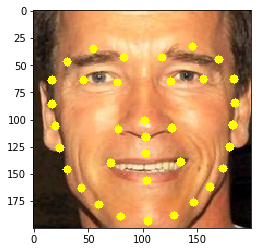

In [69]:
for i_lm in range(0,35):
    normed_x = req_handle.outputs[output_lm_net][0][2*i_lm]
    normed_y = req_handle.outputs[output_lm_net][0][(2*i_lm)+ 1]
    x_lm = xmin + width * normed_x;
    y_lm = ymin + height * normed_y;
    cv.circle(image, (int(x_lm), int(y_lm)), 1+int(0.019 * width), (0,255,255), -1)
    
plt.imshow(image[:,:,::-1])